In [1]:
import accelerator_environments
import gym
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import DDPG

In [2]:
env = gym.make("ARESExperimentalArea-Ocelot-v0")

initializing ocelot...


In [3]:
model = DDPG("CnnPolicy", env, verbose=True)
model.learn(total_timesteps=50)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
model.save("model3")

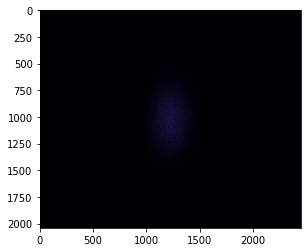

In [3]:
env.reset()
plt.imshow(env.screen_data, cmap="magma")
plt.show()

In [4]:
observation = env.reset()
i = 0
actions, observations = [], []
for _ in range(50):
    print(f"\rStep {i}: {observation}", end="")
    observations.append(observation)
    action, _state = model.predict(observation, deterministic=True)
    print(f" -> {action}", end="")
    actions.append(action)
    observation, reward, done, info = env.step(action)
    print(f" -> {reward}")
    i += 1

observations = np.array(observations)
actions = np.array(actions)

Step 0: [-0.00358784 -0.00302286  0.00052522  0.00056757] -> [-0.13485527  0.01100349  0.02455807 -0.00637577  0.01152137] -> 1000.0007054867
Step 1: [-0.00353106 -0.00298536  0.00025906  0.00022253] -> [-0.1348939   0.0111351   0.02456093 -0.00635979  0.0115208 ] -> 1000.0
Step 2: [-0.00353106 -0.00298536  0.00025906  0.00022253] -> [-0.1348939   0.0111351   0.02456093 -0.00635979  0.0115208 ] -> 1000.0
Step 3: [-0.00353106 -0.00298536  0.00025906  0.00022253] -> [-0.1348939   0.0111351   0.02456093 -0.00635979  0.0115208 ] -> 1000.0
Step 4: [-0.00353106 -0.00298536  0.00025906  0.00022253] -> [-0.1348939   0.0111351   0.02456093 -0.00635979  0.0115208 ] -> 1000.0
Step 5: [-0.00353106 -0.00298536  0.00025906  0.00022253] -> [-0.1348939   0.0111351   0.02456093 -0.00635979  0.0115208 ] -> 1000.0
Step 6: [-0.00353106 -0.00298536  0.00025906  0.00022253] -> [-0.1348939   0.0111351   0.02456093 -0.00635979  0.0115208 ] -> 1000.0
Step 7: [-0.00353106 -0.00298536  0.00025906  0.00022253] ->

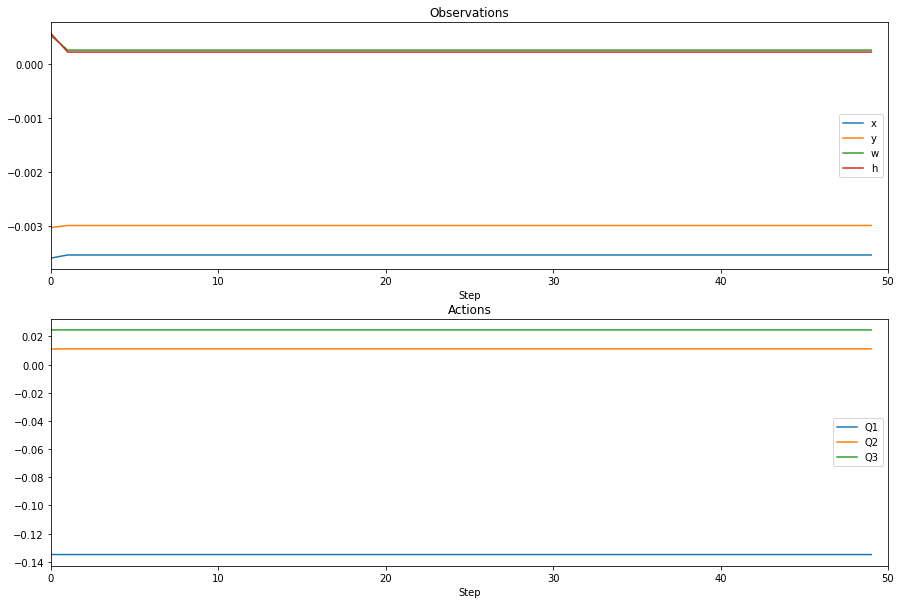

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.title("Observations")
plt.xlabel("Step")
plt.xlim(0,50)
plt.plot(observations[:,0], label="x")
plt.plot(observations[:,1], label="y")
plt.plot(observations[:,2], label="w")
plt.plot(observations[:,3], label="h")
plt.legend()
plt.subplot(212)
plt.title("Actions")
plt.xlabel("Step")
plt.xlim(0,50)
plt.plot(actions[:,0], label="Q1")
plt.plot(actions[:,1], label="Q2")
plt.plot(actions[:,2], label="Q3")
# plt.plot(actions[:,3], label="C1")
# plt.plot(actions[:,4], label="C2")
plt.legend()
plt.show()

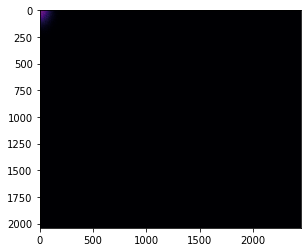

In [7]:
plt.imshow(env.screen_data, cmap="magma")
plt.show()